In [1]:
import numpy as np
import pathlib
import random
import torch
import cv2
import optimization_library as optlib

import matplotlib.pyplot as plt
import random
import functools


torch.set_printoptions(precision=3, sci_mode=False)

random.seed(0)
np.random.seed(1)
torch.manual_seed(0)

base_dir = pathlib.Path.cwd()
dlc_model_path = base_dir/"HorseInferenceFiles/DLC_Model_With_Head"
training_data_directory = base_dir / "HorseInferenceFiles"
generated_directory = base_dir/"generated"
urdf_path = base_dir/"horse_like_robot.model.urdf"
device = optlib.getTorchDevice()
print(f"Training with device: {device}")


2023-10-20 20:36:33.618663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/aman2/anaconda3/envs/DEEPLABCUT/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Training with device: cpu


In [2]:
total_video = optlib.CV2VideoReader((training_data_directory/"trainset/trimmedHorseVideo.mp4"))
total_training_data = optlib.TrainingKeypoints.init_from_video_using_dlc_model(total_video, dlc_model_path)
first_five_frames_data = total_training_data.get_subset(range(5))
robot_data = optlib.RobotData.init_from_urdf_file(urdf_path, device=device)

2023-10-20 20:36:58.209456: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-20 20:36:58.361356: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_hip_tran']/actuator[@name='FR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_thigh_tran']/actuator[@name='FR_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_calf_tran']/actuator[@name='FR_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_hip_tran']/actuator[@name='FL_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_thigh_tran']/actuator[@name='FL_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_calf_tran']/actuator[@name='FL_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_hip_tran']/actuator[@name='RR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_thigh_tran']/actuator[@name='RR_thigh_motor']
Unknown tag "hardwareInterface" 

In [3]:
robot_data.print_skeleton()

base
  trunk
    FR_pre_hip
      FR_hip
        FR_thigh
          FR_calf
            FR_foot
    FL_pre_hip
      FL_hip
        FL_thigh
          FL_calf
            FL_foot
    RR_pre_hip
      RR_hip
        RR_thigh
          RR_calf
            RR_foot
    Lower Spine
      Tail
    Upper Spine
      Ears
        Nose
          Jawline
    RL_pre_hip
      RL_hip
        RL_thigh
          RL_calf
            RL_foot


In [4]:
#Basically we define points on the robot in terms of the link that starts at the joint, and the image is defined in terms of the joint at the position
#For example, a knee on the robot is called a calf since the calf starts at the knee joint, and a knee in the image
robot_image_mapping = {
 'trunk' : None,
 'imu_link' : None,
 'FR_hip' : None,
 'FR_thigh': "Shoulder",
 'FR_calf': "Front Right Knee",
 'FR_foot': "Front Right Ankle",
 'FL_hip': None,
 'FL_thigh': "Shoulder",
 'FL_calf': "Front Left Knee",
 'FL_foot': "Front Left Ankle",
 'RR_hip': None,
 'RR_thigh': "Hip",
 'RR_calf': "Back Right Knee",
 'RR_foot': "Back Right Ankle",
 'RL_hip': None,
 'RL_thigh': "Hip",
 'RL_calf': "Back Left Knee",
 'RL_foot' : "Back Left Ankle",
 'Lower Spine': "End of Tail",
 'Tail': "Tip of Tail",
 'Upper Spine': "End of Neck",
 'Ears': "Ears",
 'Nose': "Nose",
 'Jawline': "Jaw",
}

#Removed all None entries
robot_image_mapping = {key:robot_image_mapping[key] for key in robot_image_mapping if robot_image_mapping[key] is not None}

robot_joints_in_order = list(robot_image_mapping.keys())
image_keypoint_orders = [robot_image_mapping[j] for j in robot_joints_in_order]

These are aligned lists, so that we can start putting them in tensors and the alignment will be implicit once they're in tensors.

## Training Loop

In [5]:
trainingFrames = []
draw_on_image = None

In [13]:
robot_data.make_limb_length_learnable()

class TrainingVariables():
    def __init__(self,*, joint_angles, fx, fy, u0, v0, tx, ty, tz, extrinsicRotationQuaternion):
        self.joint_angles = joint_angles
        self.fx = fx
        self.fy = fy
        self.u0 = u0
        self.v0 = v0
        self.tx = tx
        self.ty = ty
        self.tz = tz
        self.extrinsicRotationQuaternion = extrinsicRotationQuaternion
    @classmethod
    def initialize_from_initials(cls, *,frame_count: int, joint_angles: "(n.joints,)", fx: float, fy: float, u0: float, v0: float, tx: float, ty: float, tz: float, extrinsicRotationQuaternion:"(4) tensor"):
        joint_angles = joint_angles.repeat(frame_count,1).requires_grad_(True)

        differentiableConstantTensor = lambda constant: torch.tensor(float(constant), requires_grad=True)
        
        fx = differentiableConstantTensor(fx)
        fy  = differentiableConstantTensor(fy)
        u0 = differentiableConstantTensor(u0)
        v0 = differentiableConstantTensor(v0)



        tx = torch.ones((frame_count,))*tx
        tx = tx.requires_grad_(True)
        ty = torch.ones((frame_count,))*ty
        ty = ty.requires_grad_(True)
        tz = torch.ones((frame_count,))*tz
        tz = tz.requires_grad_(True)

        #Zero rotation quaternion
        #Good visualization resource: https://quaternions.online
        #JS Script to get as tensor (paste into console): 
        # xPathResults = document.evaluate('//*[@id="container"]/div[2]/table[1]//*[contains(@class, "quaternionInput")]',document,null,XPathResult.ORDERED_NODE_SNAPSHOT_TYPE,null); console.log(`torch.tensor([${Array.from(Array(4).keys()).map(i => xPathResults.snapshotItem(i).value).join(",")}])`);
        extrinsicRotationQuaternion = extrinsicRotationQuaternion.unsqueeze(0) * torch.ones((frame_count,4))
        extrinsicRotationQuaternion = extrinsicRotationQuaternion.requires_grad_(True)
        return cls(joint_angles=joint_angles, fx=fx, fy=fy, u0=u0, v0=v0, tx=tx, ty=ty, tz=tz, extrinsicRotationQuaternion=extrinsicRotationQuaternion)
    def get_as_initials(self):
        joint_angles = self.joint_angles[0].detach().clone()
        tx = self.tx[0]
        ty = self.ty[0]
        tz = self.tz[0]
        extrinsicRotationQuaternion = self.extrinsicRotationQuaternion[0].detach().clone()
        return{
            "joint_angles": joint_angles,
            "fx": float(self.fx),
            "fy": float(self.fy),
            "u0": float(self.u0),
            "v0": float(self.v0),
            "tx": float(tx),
            "ty": float(ty),
            "tz": float(tz),
            "extrinsicRotationQuaternion": extrinsicRotationQuaternion
        }



In [25]:
%matplotlib inline
VERBOSE = True
def train(*,training_variables, training_data: optlib.TrainingKeypoints,robot_data: optlib.RobotData, training_mode = "All"):
    global draw_on_image
    global trainingFrames
    joint_angles = training_variables.joint_angles
    fx = training_variables.fx
    fy = training_variables.fy
    u0 = training_variables.u0
    v0 = training_variables.v0
    tx = training_variables.tx
    ty = training_variables.ty
    tz = training_variables.tz
    extrinsicRotationQuaternion = training_variables.extrinsicRotationQuaternion
    learnable_robot_model = robot_data.robot_model
    imgCount = training_data.get_frame_count()
    TRAINING_MODES = {
    "All": torch.optim.Adam([fx,fy,u0,v0,tx,ty,tz,extrinsicRotationQuaternion, joint_angles]+ list(learnable_robot_model.parameters()), lr=1e-3),
    "All -Lengths": torch.optim.Adam([fx,fy,u0,v0,tx,ty,tz,extrinsicRotationQuaternion, joint_angles], lr=1e-3),
    "Camera Properties": torch.optim.Adam([fx,fy,u0,v0,tx,ty,tz,extrinsicRotationQuaternion], lr=1e-2),
    }
    optimizer = TRAINING_MODES[training_mode]
    optimizer.zero_grad()

    constantTensor = optlib.constantTensor
    intrinsic = torch.vstack([
        torch.hstack([fx,constantTensor(0), u0]),
        torch.hstack([constantTensor(0),fy, v0]),
        torch.hstack([constantTensor(0),constantTensor(0), constantTensor(1)])
    ])

    formatTensor = torch.tensor([1.0,0.0,0.0])
    xComponent = tx.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))
    formatTensor = torch.tensor([0.0,1.0,0.0])
    yComponent = ty.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))
    formatTensor = torch.tensor([0.0,0.0,1.0])
    zComponent = tz.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))

    extriniscTransformation = xComponent + yComponent + zComponent
    extrinsicRotation = optlib.pytorch3d.transforms.quaternion_to_matrix(extrinsicRotationQuaternion)
    extriniscTransformation = extriniscTransformation.reshape(imgCount,3,1)
    extrinsic = torch.cat((extrinsicRotation, extriniscTransformation),2)
    
    
    #Get Robot Projection
    robotEEPositions = learnable_robot_model.compute_forward_kinematics_all_links(joint_angles)
    #Prune Rotation Information 
    robotEEPositions = {linkName: robotEEPositions[linkName][0] for linkName in robotEEPositions}
    #If Only One Entry Duplicate Data
    for jointName in robotEEPositions:
        if robotEEPositions[jointName].shape[0] != imgCount:
            robotEEPositions[jointName] = robotEEPositions[jointName].repeat(imgCount,1)
    jointPosition = torch.hstack([robotEEPositions[joint].unsqueeze(1) for joint in robot_joints_in_order])
    jointCameraPositions = optlib.calculateCameraProjection(intrinsic, extrinsic, jointPosition)
    pixelLoss = torch.sum(torch.sqrt(torch.sum(torch.pow(jointCameraPositions.reshape(-1,2) - ((training_data.keypoints).reshape(-1,2)), 2),-1)))
           


    loss = pixelLoss + 10* optlib.losses.totalLimbLength(robot_data, relu=True,reluThreshold = 1) + optlib.losses.interframeJointLoss(joint_angles) + optlib.losses.out_of_frame_loss(intrinsic,extrinsic, total_video, robotEEPositions, scalar = 100)
    draw_on_image = functools.partial(optlib.drawPredictionOnImage, intrinsic=intrinsic, extrinsic=extrinsic, robotEEPositions=robotEEPositions, training_dataset = training_data, robot_data=robot_data)
    n = 100
    if epoch % n == 0 and VERBOSE:
        #Print every n epoch's including the 0th one
        print(f"Epoch {epoch}: Loss ({pixelLoss}), Loss Per Entry ({loss/jointCameraPositions.reshape(-1,2).shape[0]} pixels)")
    trainingFrames.append(draw_on_image(image_index=0))
    n = 100
    if epoch % n == 0 and VERBOSE:        
        plt.clf()
        plt.imshow(draw_on_image(image_index=0))
        plt.show()
    loss.backward()
    optimizer.step()

Epoch 0: Loss (11713.7197265625), Loss Per Entry (130.15243530273438 pixels)


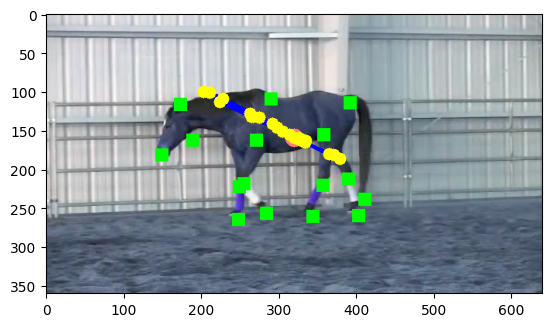

Finished stage 1
Epoch 0: Loss (10273.6123046875), Loss Per Entry (114.1512451171875 pixels)


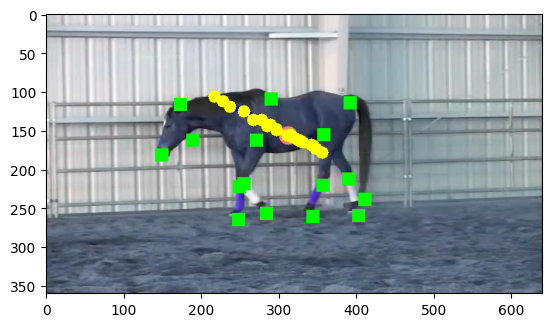

Finished stage 2
Epoch 0: Loss (2400034.75), Loss Per Entry (114.35271453857422 pixels)


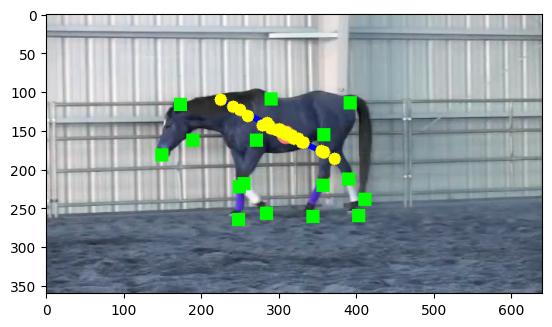

Finished all training


In [57]:
init_angles = torch.zeros((1,len(robot_data.get_link_names())))
training_data = first_five_frames_data.reordered_training_set(image_keypoint_orders)
training_variables = TrainingVariables.initialize_from_initials(frame_count = training_data.get_frame_count(), joint_angles=init_angles, fx=10, fy=10, u0=320, v0=160, tx=0, ty=0, tz=1, extrinsicRotationQuaternion=torch.tensor([0,0,0,1]))
learnable_robot_model = robot_data.robot_model

for epoch in range(10):
    train(training_variables=training_variables, training_data = training_data, robot_data = robot_data, training_mode="Camera Properties")
print("Finished stage 1")
for epoch in range(10):
    train(training_variables=training_variables, training_data = training_data, robot_data = robot_data, training_mode="All")
print("Finished stage 2")
training_data = total_training_data.reordered_training_set(image_keypoint_orders)
training_variables = training_variables.initialize_from_initials(**training_variables.get_as_initials(), frame_count=training_data.get_frame_count())
for epoch in range(1):
    train(training_variables=training_variables, training_data = training_data, robot_data = robot_data, training_mode="All")
print("Finished all training")

In [44]:
if not generated_directory.exists():
    generated_directory.mkdir(parents=True)

In [45]:
#Export video of training
vidOut = cv2.VideoWriter(str(generated_directory/'training_video.mp4'),cv2.VideoWriter_fourcc(*'mp4v'), 1, (640,360))
for frame in trainingFrames:
    vidOut.write(frame)
vidOut.release()

In [46]:
#Export video of the frames
vidOut = cv2.VideoWriter(str(generated_directory/'final_video_horse_based.mp4'),cv2.VideoWriter_fourcc(*'mp4v'), 10, (640,360))
for index in range(training_data.get_frame_count()):
    vidOut.write(draw_on_image(image_index=index))
vidOut.release()

In [50]:
robot_data.write_to_urdf_file(str(generated_directory/"generatedURDF.urdf"))

In [47]:
#TODO: Write limb lengths to new urdf file (export function)
import shutil
exported_robot_path = str(generated_directory/"generatedURDF.urdf")
shutil.copyfile(str(urdf_path), exported_robot_path)

'/Users/aman2/Documents/GitHub/DiffRobotA1/generated/generatedURDF.urdf'

In [48]:
import xml
tree = xml.etree.ElementTree.parse(exported_robot_path)
root = tree.getroot()
root.tag

'robot'

In [49]:
for joint in root.findall("joint"):
    name = joint.find("./child").get('link')
    desiredXYZ = optlib.getLinksLength(learnable_robot_model,name)
    currentXYZ = joint.find("origin").get("xyz")
    formattedDesiredXYZ = " ".join(map(str, desiredXYZ.reshape(3).tolist()))
    print(f"{name}")
    print(f"\tChanging XYZ from '{currentXYZ}' to '{formattedDesiredXYZ}'")
    joint.find("origin").set("xyz", formattedDesiredXYZ)
tree.write(exported_robot_path)
print("Saved changes to file in generated directory")

trunk
	Changing XYZ from '0 0 0' to '0.0 0.0 0.0'
FR_pre_hip
	Changing XYZ from '-0.1805 0.047 0' to '-0.18050000071525574 0.04699999839067459 0.0'
FR_hip
	Changing XYZ from '0.1805 -0.047 0' to '0.18050000071525574 -0.04699999839067459 0.0'
FR_thigh
	Changing XYZ from '0 -0.0838 0' to '0.0 -0.08380000293254852 0.0'
FR_calf
	Changing XYZ from '0 0 -0.2' to '0.0 0.0 -0.20000000298023224'
FR_foot
	Changing XYZ from '0 0 -0.2' to '0.0 0.0 -0.20000000298023224'
FL_pre_hip
	Changing XYZ from '-0.1805 0.047 0' to '-0.18050000071525574 0.04699999839067459 0.0'
FL_hip
	Changing XYZ from '0.1805 0.047 0' to '0.18050000071525574 0.04699999839067459 0.0'
FL_thigh
	Changing XYZ from '0 0.0838 0' to '0.0 0.08380000293254852 0.0'
FL_calf
	Changing XYZ from '0 0 -0.2' to '0.0 0.0 -0.20000000298023224'
FL_foot
	Changing XYZ from '0 0 -0.2' to '0.0 0.0 -0.20000000298023224'
RR_pre_hip
	Changing XYZ from '-0.1805 0.047 0' to '-0.18050000071525574 0.04699999839067459 0.0'
RR_hip
	Changing XYZ from '-0.18

In [ ]:
[fx,fy,u0,v0,tx,ty,tz,extrinsicRotationQuaternion]

[tensor(14.270, requires_grad=True),
 tensor(27.526, requires_grad=True),
 tensor(318.930, requires_grad=True),
 tensor(161.341, requires_grad=True),
 tensor([-0.199, -0.204, -0.203, -0.189, -0.188], requires_grad=True),
 tensor([-1.475, -1.475, -1.475, -1.471, -1.472], requires_grad=True),
 tensor([0.992, 0.992, 0.993, 0.992, 0.992], requires_grad=True),
 tensor([[-0.282, -0.169,  0.059,  0.729],
         [-0.282, -0.169,  0.059,  0.728],
         [-0.282, -0.170,  0.059,  0.728],
         [-0.282, -0.170,  0.060,  0.730],
         [-0.282, -0.170,  0.060,  0.731]], requires_grad=True)]

ERobot: a1 (by File Import), 22 joints (RRRRRRRRRRRRRRRRRRRRRR), 6 branches, dynamics, geometry, collision
┌─────┬─────────────┬───────┬─────────────┬────────────────────────────────────────────┐
│link │    link     │ joint │   parent    │            ETS: parent to link             │
├─────┼─────────────┼───────┼─────────────┼────────────────────────────────────────────┤
│   0 │ base        │       │ BASE        │ SE3()                                      │
│   1 │ trunk       │       │ base        │ SE3()                                      │
│   2 │ FR_pre_hip  │     0 │ trunk       │ SE3(0.2363, -0.9137, 0.4699) ⊕ Ry(q0)      │
│   3 │ FR_hip      │     1 │ FR_pre_hip  │ SE3(0.4686, -1.008, 0.5024) ⊕ Rx(q1)       │
│   4 │ FR_thigh    │     2 │ FR_hip      │ SE3(0.2881, -1.224, 0.405) ⊕ Ry(q2)        │
│   5 │ FR_calf     │     3 │ FR_thigh    │ SE3(-0.4313, -3.671, -0.02452) ⊕ Ry(q3)    │
│   6 │ @FR_foot    │       │ FR_calf     │ SE3(0, 0, -0.2)                            │
│  

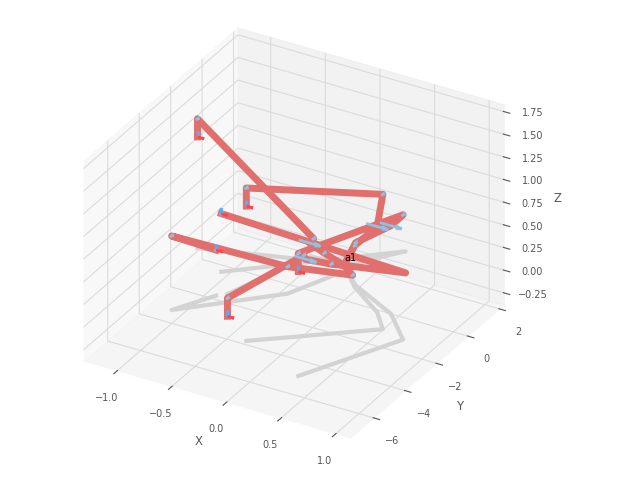

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'a1')

In [ ]:
import numpy as np
from roboticstoolbox.robot.ERobot import ERobot
from math import pi
import pathlib

base_dir = pathlib.Path.cwd()
generated_directory = base_dir/"generated"

class RobotXML(ERobot):

    def __init__(self):

        links, name, urdf_string, urdf_filepath = self.URDF_read(
            exported_robot_path
        )

        super().__init__(
            links,
            name=name,
            urdf_string=urdf_string,
            urdf_filepath=urdf_filepath,
        )

        self.manufacturer = "File Import"


robot = RobotXML()
print(robot)

%matplotlib widget
robot.plot(np.zeros(robot.n), backend="pyplot")